NVIDIA GeForce GTX 1650
Model file 'd:\INTERNSHIP\Task4\../models\colorization_model_full.pth' found. Loading model...


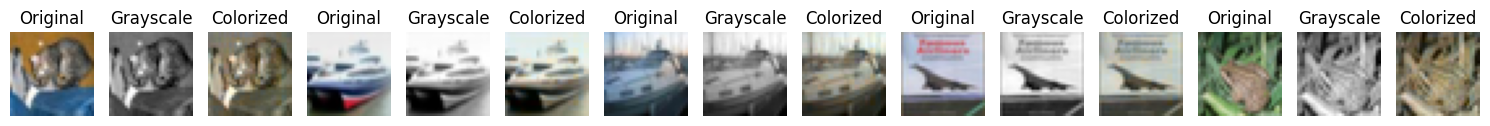

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import os
import matplotlib.pyplot as plt
import numpy as np
from skimage.color import rgb2lab, lab2rgb

# ================== DEVICE SETUP ==================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))
else:
    print("No NVIDIA driver found. Using CPU")

# ================== PATH SETUP ==================
project_root = os.getcwd()
data_root = os.path.join(project_root, "../data")
os.makedirs(os.path.join(project_root, "../models"), exist_ok=True)
model_path = os.path.join(project_root, "../models", "colorization_model_full.pth")
weights_path = os.path.join(project_root, "../models", "colorization_model_full_weights.pth")

# ================== DATASET ==================
download_flag = not os.path.exists(os.path.join(data_root, 'cifar-10-batches-py'))

# Enhanced data augmentation
train_transform = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=0, translate=(0.3, 0.3), shear=0.3),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
    transforms.ToTensor()
])
test_transform = transforms.Compose([transforms.ToTensor()])

train_dataset = torchvision.datasets.CIFAR10(root=data_root, train=True, download=download_flag, transform=train_transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0)

test_dataset = torchvision.datasets.CIFAR10(root=data_root, train=False, download=download_flag, transform=test_transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=0)

# ================== MODEL DEFINITION ==================
class ColorizationNet(nn.Module):
    def __init__(self):
        super(ColorizationNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=5, stride=1, padding=4, dilation=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=4, dilation=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=5, stride=1, padding=4, dilation=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=5, stride=1, padding=4, dilation=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=5, stride=1, padding=4, dilation=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 2, kernel_size=5, stride=1, padding=4, dilation=2),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Perceptual loss using pre-trained VGG16
class PerceptualLoss(nn.Module):
    def __init__(self):
        super(PerceptualLoss, self).__init__()
        vgg = models.vgg16(weights=models.VGG16_Weights.DEFAULT).features[:16].to(device).eval()
        for param in vgg.parameters():
            param.requires_grad = False
        self.vgg = vgg
        self.mse = nn.MSELoss()

    def forward(self, pred, target):
        pred_rgb = torch.cat([torch.zeros_like(pred[:, :1]), pred], dim=1)
        target_rgb = torch.cat([torch.zeros_like(target[:, :1]), target], dim=1)
        return self.mse(self.vgg(pred_rgb), self.vgg(target_rgb))

criterion_mse = nn.MSELoss()
criterion_perceptual = PerceptualLoss()

# ================== LAB conversion helpers ==================
def rgb_to_lab(img):
    img_np = img.permute(0, 2, 3, 1).cpu().numpy()
    lab = np.zeros_like(img_np)
    for i in range(img_np.shape[0]):
        lab[i] = rgb2lab(img_np[i])
    lab = torch.tensor(lab).permute(0, 3, 1, 2).to(device)
    lab[:, 0, :, :] = lab[:, 0, :, :] / 100.0
    lab[:, 1:, :, :] = (lab[:, 1:, :, :] + 128) / 255.0
    return lab[:, 0:1, :, :], lab[:, 1:, :, :]

def lab_to_rgb_torch(l, ab):
    l = l.cpu().numpy()
    ab = ab.detach().cpu().numpy()
    imgs = []
    for i in range(l.shape[0]):
        lab = np.zeros((32, 32, 3))
        lab[:, :, 0] = l[i, 0] * 100.0
        lab[:, :, 1:] = (ab[i].transpose(1, 2, 0) * 255.0) - 128
        rgb = lab2rgb(lab)
        imgs.append(rgb)
    return np.stack(imgs)

# ================== TRAIN / LOAD MODEL ==================
def load_or_train_model():
    model = ColorizationNet().to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

    if os.path.exists(model_path):
        print(f"Model file '{model_path}' found. Loading model...")
        model = torch.load(model_path, map_location=device, weights_only=False)
        model.to(device)
    else:
        print("No existing model found. Starting training...")
        EPOCHS = 10
        for epoch in range(EPOCHS):
            model.train()
            running_loss = 0.0
            for i, (images, _) in enumerate(train_loader):
                images = images.to(device)
                l, ab = rgb_to_lab(images)
                outputs = model(l)
                loss_mse = criterion_mse(outputs, ab)
                loss_perceptual = criterion_perceptual(outputs, ab)
                loss = 0.7 * loss_mse + 0.3 * loss_perceptual
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
                if i % 100 == 0:
                    print(f"Epoch [{epoch+1}/{EPOCHS}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}")
            avg_loss = running_loss / len(train_loader)
            print(f"Epoch [{epoch+1}/{EPOCHS}], Average Loss: {avg_loss:.4f}")
            scheduler.step(avg_loss)

        print("Finished Training")
        torch.savea(model, model_path)
        torch.save(model.state_dict(), weights_path)
    return model

# ================== VISUALIZATION ==================
def visualize_all_three(original_images, grayscale_images, colorized_images, n=5):
    fig = plt.figure(figsize=(3*n, 4))
    for i in range(n):
        plt.subplot(1, 3*n, 3*i + 1)
        plt.imshow(original_images[i]); plt.title("Original"); plt.axis("off")
        plt.subplot(1, 3*n, 3*i + 2)
        plt.imshow(grayscale_images[i], cmap='gray'); plt.title("Grayscale"); plt.axis("off")
        plt.subplot(1, 3*n, 3*i + 3)
        plt.imshow(colorized_images[i]); plt.title("Colorized"); plt.axis("off")
    plt.tight_layout(); plt.show()

# ================== TEST VISUALIZATION ==================
def test_visualization(model):
    model.eval()
    with torch.no_grad():
        for i, (images, _) in enumerate(test_loader):
            images = images.to(device)
            l, ab = rgb_to_lab(images)
            pred_ab = model(l)
            pred_rgb = lab_to_rgb_torch(l[:5], pred_ab[:5])
            orig_rgb = lab_to_rgb_torch(l[:5], ab[:5])
            grayscale_images = l[:5].cpu().squeeze(1)
            visualize_all_three(orig_rgb, grayscale_images, pred_rgb)
            break

# ================== MAIN EXECUTION ==================
if __name__ == "__main__":
    model = load_or_train_model()
    test_visualization(model)
